# Project: Risk/Reward ratio's
    Max Keuken (mckeuken@gmail.com)
    Code contributers: Niek Stevenson, Scott Isherwood, Steven Militic
    UvA, Amsterdam, The Netherlands
## Goal of the code 
    Generate design files that Niek Stevenson can use on the TransIP server to run the Risk/Reward decision-making paradigm
     
    The paradigm is based on Bongioanni et al. (2021) where they trained macaque's to perform a 2 forced choice alternative 
    decision making task. The task entails that two stimuli of dots surrounded by a rectangular border and are shown on the 
    left and right side of the screen. The stimuli are varied on two dimensions: 
        - the number of dots (range between 3 and 30, steps of 3) 
        - and the color of the dots (viridis green-blue)
    The number of dots indicated the probability of reward whereas the color of the dots indicated the magnitude of the 
    reward. 
    
    The interesting thing of this task is that it consists of a training and test phase. The training phase entails
    a subset of trials that either have a constant color (and varying number of dots) or constant number of dots (and varying
    color range). This means that the macaques are heavily trained on a subset of trials which are later also used in the test
    phase and thus resulting in familiar and novel trials. There was another axis in which the trials varied:
         - consistent (based on both the color and number of dots you should prefer one over the other option
         - inconsistent (the color and number of dots indicate conflicting info)
         - 1D (the two choices were identical on one of the two dimensions but varied on the other) 
    
    Ideally we would want to have this paradigm for humans as it allows you to test a whole range of interesting questions but 
    to do so we would need to change a number of things:
        - change the timing for fMRI speed
        - introduce a response deadline
        - probably reduce the number of trials 
    

## Import Modules and set paths

In [4]:
###############################################################################################
# Import modules and set paths
###############################################################################################

# We are using the following modules, most of which should already be part of the anaconda 
#. installation. 
from __future__ import division
import pandas as pd
import numpy as np
import os
import glob as glob
import matplotlib.pyplot as plt 
from itertools import groupby
import seaborn as sns
from itertools import combinations
from math import pi, sqrt, cos, sin
import random
import warnings

# If not: 
# You probably want to install that extra module via pip through a terminal
#. See the following page for the instructions how to install PIP
#. if you don't have it already: 
#. https://pip.pypa.io/en/stable/installation/
# Once you have pip installed you can now type the following on your terminal:
#. python -m pip install 'module name'

# Setting folder structure
projectDir = '~/Documents/Werk.nosynch/Shared/Risk-Reward-DM'
taskDir = projectDir+'/Paradigm'
taskDesignDir = taskDir+'/GenerateDesignFiles'
taskDesignOutputDir = taskDesignDir+'/designFiles'

# The first author shared a design file with me and can be found here:
exampleTrialLayout = taskDir+'/Original/behav_choice_w12.txt'

print('Loading all modules and set paths succes')
###############################################################################################

Loading all modules and set paths succes


## Define a number of custom functions

In [5]:
###############################################################################################
# Define a number of functions
###############################################################################################
####
# Trial type related:

# Determine if a choice combination between left and right are BOTH familiar or BOTH novel
def ChoiceOptions(Options_left, Options_right):
    if (Options_left == Options_right ) & ((Options_left == 'novel')):
        return 'novel'
    elif (Options_left == Options_right ) & ((Options_left == 'familiar')):
        return 'familiar'
    else:
        return 'mixed'

# Determine if a choice combination between left and right is consistent, 1-d or Inconsistent
def ChoiceDim(MagReward_left, MagReward_right, ProbReward_left, ProbReward_right):
    if (MagReward_left > MagReward_right ) & ((ProbReward_left > ProbReward_right )):
        return 'consistent'
    elif (MagReward_left < MagReward_right ) & ((ProbReward_left < ProbReward_right )):
        return 'consistent'
    elif (MagReward_left == MagReward_right ) | ((ProbReward_left == ProbReward_right )):
        return '1D'
    else:
        return 'inconsistent'

# Determine if a choice option falls within or outside the trained range of expected rewards
def outsideFamiliarRange(MagReward_left, MagReward_right, ProbReward_left, ProbReward_right):
    if (MagReward_left * ProbReward_left < MagnitudeRewardTraining*0.1):
        return 'untrained'
    elif (MagReward_right * ProbReward_right < MagnitudeRewardTraining*0.1):
        return 'untrained'
    elif (MagReward_left * ProbReward_left > ProbabilityRewardTraining*10):
        return 'untrained'
    elif (MagReward_right * ProbReward_right > ProbabilityRewardTraining*10):
        return 'untrained'
    else:
        return 'trained'

####
# Related to the dots
# Code by Niek
# Create the coordinates for the n number of dots:
def createDots(nDots, canvasDim, dotRadius, borderMargin, dotsMargin):
    dots = []
    for i in range(nDots):
        notAccepted = True
        while notAccepted:
            radius = (canvasDim/2 - dotRadius - borderMargin) * sqrt(random.uniform(0,1)) #Make sure they don't hit the border
            angle = random.uniform(0,1) * 2 * pi
            x = canvasDim/2 + radius * cos(angle)
            y = canvasDim/2 + radius * sin(angle)
            if i > 0:
                notAccepted = False
                for j in range(len(dots)):
                    # Check if the euclidean distance is smaller than the critical value, 
                    #. if so, then keep going
                    distance = np.linalg.norm(np.array((x, y)) - np.array((dots[j][0], dots[j][1]))) 
                    if distance < (dotRadius*2 + dotsMargin):
                        notAccepted = True
                if not notAccepted:
                    x = int(x)
                    y = int(y)
                    dots.append([x, y])
            else:
                x = int(x)
                y = int(y)
                dots.append([x, y])
                notAccepted = False
    return(dots)

####
# Pseudo randomizer function
# Code Scott and Steven
class Pseudorandomizer(object):
    
    def __init__(self, data, max_identical_iters={'type_of_trial': 2}):  
        self.data = data
        self.max_identical_iters = {x: y+1 for x, y in list(max_identical_iters.items())}
                                    # add 1: if 4 rows is allowed, only give an error after 5 identical rows
    
    def check_trial_rows(self, data, row_n): 
        """
        Returns True if any of the conditions for pseudorandomization are violated for the given rows, 
        False if they are fine.
        """
        
        # First, check for the maximum iterations
        for column, max_iter in list(self.max_identical_iters.items()):
            if row_n - max_iter < 0:
                continue

            # Select rows [max_iter-1 - row_n] we're going to check. Never select any row with index < 0
            row_selection = [x for x in np.arange(row_n, row_n-max_iter, -1)]

            # Next, we check if the selected rows only contain *1* trial type. 
            # If so, this means we have max_iter rows of the same trials, and we need to change something.
            if data.iloc[row_selection][column].nunique() == 1:
                return True

        return False

    def run(self, debug=False):
        """
        Pseudorandomizes: makes sure that it is not possible to have more than x iterations for every type of column, specified in columns.
        """
        print("pseudorandomizer running")
        
        # Start by copying from original data, and shuffle
        self.data = self.data.sample(frac=1, random_state=np.random.randint(0, 1e7, dtype='int')).reset_index(drop=True) 
        
        if debug:
            outer_while_i = 0
            debug_print_after_i = 100

        good_set = False
        while not good_set:
            if debug:
                outer_while_i += 1

            reshuffle = False  # Assume the dataset does not need reshuffling.
            for row_n in range(0, self.data.shape[0]):

                # Check if the current row, and the (max_iters-1) rows before, are the same value (number of unique values = 1).
                # If so, then move the current row number to the bottom of the dataframe. However, we need to re-check the same four rows again
                # after moving a row to the bottom: therefore, a while loop is necessary.
                checked_row = False
                n_attempts_at_moving = 0
                
                if debug:
                    inner_while_i = 0
                
                while not checked_row:
                    if debug:
                        inner_while_i += 1
                        if inner_while_i > debug_print_after_i:
                            print('New inner loop started for current row')

                    if self.check_trial_rows(self.data, row_n):
                        if debug and inner_while_i > debug_print_after_i:
                            print('Found too many consecutively identical rows.')

                        # If there are too many consecutively identical rows at the bottom of the dataframe, 
                        # break and start over/shuffle
                        if row_n >= (self.data.shape[0] - self.max_identical_iters[list(self.max_identical_iters.keys())[0]]):
                            if debug and inner_while_i > debug_print_after_i:
                                print(('These occurred at row_n %d, which is at the bottom of the DF.' % row_n))

                            checked_row = True
                            reshuffle = True

                        # Too many consecutive identical rows? Move row_n to the bottom, and check again with the new row_n.
                        else:
                            if debug and inner_while_i > debug_print_after_i:
                                print(('These occurred at row_n %d. Checking the remainder of the DF.' % row_n))

                            # Check if moving to the bottom even makes sense: if all remaining values are identical, it doesn't.
                            if (self.data.iloc[row_n:][list(self.max_identical_iters.keys())].nunique().values < 2).any():
                                if debug and inner_while_i > debug_print_after_i:
                                    print('All remaining values are identical. I should stop the for-loop, and start over.')

                                checked_row = True
                                reshuffle = True
                            else:
                                if n_attempts_at_moving < 50:
                                    n_attempts_at_moving += 1

                                    if debug and inner_while_i > debug_print_after_i:
                                        print('Not all remaining values are identical. I should move the final part to the bottom.')

                                    # If not, move the current row to the bottom
                                    row_to_move = self.data.iloc[row_n,:]

                                    # Delete row from df
                                    self.data.drop(row_n, axis=0, inplace=True)

                                    # Append original row to end. Make sure to reset index
                                    self.data = self.data.append(row_to_move).reset_index(drop=True)

                                # If we already tried moving the current row to the bottom for 50 times, let's forget about it and restart
                                else:
                                    checked_row = True
                                    reshuffle = True
                    else:
                        if debug and inner_while_i > debug_print_after_i:
                            print('Checked row, but the row is fine. Next row.')
                        checked_row = True

                if reshuffle:
                    good_set = False
                    break  # out of the for loop

                # Reached the bottom of the dataframe, but no reshuffle call? Then we're set.
                if row_n == self.data.shape[0]-1:
                    good_set = True

            if reshuffle:
                # Shuffle, reset index to ensure trial_data.drop(row_n) rows
                self.data = self.data.sample(frac=1, random_state=np.random.randint(0, 1e7, dtype='int')).reset_index(drop=True)
        
        print("Finished Pseudorandomizer")
        return self.data

#### 
# Related to the timing
# Inter trial interval (ITI) is sampled from an exponential distribution
def createITIDist(lowerRange, upperRange): 
    #. So lets first create that distribution:
    #. scale is 0.5 which results in a sharper decrease so that you have
    #. relatively more shorter timings
    expDist = np.random.exponential(0.5, 10000) 

    # How does it look?
    #count, bins, ignored = plt.hist(expDist, 100, density = True) 
    #plt.show()

    # Select the ITIs that fall within the lower and upper range:
    expDistSelection = expDist[((expDist>= lowerRange) & (expDist<= upperRange))]
    
    return(expDistSelection)

####
print('All functions and ITI distributions are defined')

All functions and ITI distributions are defined


## Provide the experimental parameters and generate all trial options

In [6]:
###############################################################################################
# Provide the experimental parameters and generate all trial options
###############################################################################################
# Based on the orginal paper there are a number of criteria that need to be set:
#. During training:
#.  what fixed magnitude are you going to use during training? 
#.  what fixed probability are you going to use during training?
#.  How any trials are you going to use for the training?
#
#. During the test phase:
#.  what is the average sum of the expected value per trial over trial types (6 different options)
#.  what is the range in which the average sum of the expected value over trial types is allowed to vary?
#.  

###################################
# Parameters for the design files
###################################
# Trial type related
nrSubjects = 10 # How many test design files do you want to make?
MagnitudeRewardTraining = 5.0 # Original paper uses 5.0
ProbabilityRewardTraining = 0.6 # Original paper uses 0.6    
nrTrainingBlock = 10 # Number of mini blocks 
nrTrialsPerTrainingBlock = 30  # Original paper uses 180 trials per block but had a lot of practice blocks; 
                                #. Note that we have 199 combinations if you mix the probability and magnitude training trials
                                #.  so anything below this number will result in the chance of choice options that we labeled as 
                                #. familiar which are actually not
nrTrialsPerTestBlock = 180 # Original paper uses 180
nrTestBlocksPerSubject = 2 # Number of test blocks

nrPilotVersions = 2 # We want to try out a number of different versions during piloting
typeOfPilot = 'memoryChunking'  # memoryChunking: original experiment is between 3 and 30, steps of 3; but what about chunking of 3 and 6 vs de rest?
                                #. so we also want to test what happens if you start at 13, steps of 3 
# The folloing are the conditional statements
#.  Changing these will make it a lot slower or faster depending on what you pick
averageExpectedValuePerType = 6.0 # Original paper uses 6.0   
rangeOfExpectedValue = 0.5 # Original paper states +/- 0.02 // change to 0.2 to speed the json file generator up
averageDifferenceValueCrit = 0.5 # Original paper states 0.02 // change to 0.2 to speed the json file generator up
stdDifferenceValueCrit = 0.5 # Original paper states 0.0035 variance which is pretty tight.. // change to 0.5 to speed the json file generator up
                             #. After emailing back and forth with main author, the idea
                             #. came up that using a standard deviation threshold is more
                             #. elegant than using the variance. So instead we are going 
                             #. to use the STD deviation with slightly wider width
maxCorrelationBestWorst = 0.5 # Original paper uses 0.33 between novel and familiar 
onlyUniqueTrials = False # Orginal paper has duplicates
maximumTrialTypeRep = 2 # Orginal paper in matlab code states 6

# Visual Stimulus related
canvasDim = 300 # The size of the canvas in number of pixels
dotRadius =  canvasDim / 50 # The radius of the dots in relation to the overal canvas size
borderMargin = 25 # Minimum distance between dot and border
dotsMargin = 10 # Minimum distance between two dots
numberOfDotsMagnitudeRatio = 3 # Original paper uses 3
colorScheme = 'viridis' # Original paper uses viridis, other potential option would be 'coolwarm'

# Timing related (in seconds)
itiLowerRange = 0.1 # Pre-fixation cross empty screen minimum duration
itiUpperRange = 0.75 # Pre-fixation cross empty screen maximum duration
fixationDuration = 0.5 # Duration of fixation cross to indicate start of trial
stimulusDuration = 2.5 # Change based on difficulty
itiPostStimulusDuration = 0.5
feedbackDuration = 1.0 # Duration of feedback
totalTrialDuration = 6.0 # Post-fixation empty screen is based on intial pre-fixation ITI and maximum trial length 

###################################
print('You provided all parameters, right?')


You provided all parameters, right?


Pilot version: 0

After filtering, the number of potential trials to sample from:

ChoiceOption  ChoiceDimension
familiar      1D                  199
              consistent           82
              inconsistent         80
novel         1D                  776
              consistent          816
              inconsistent       2008
dtype: int64

The overal mean expected value per trial type where 6.0 +/- 0.02 is oke:

ChoiceOption  ChoiceDimension
familiar      1D                 6.050251
              consistent         6.085366
              inconsistent       6.025000
novel         1D                 4.816237
              consistent         5.166422
              inconsistent       4.597012
Name: expectedValueSum, dtype: float64

Expected number of trials per subject?

Total number of training trials: 30
Total number of test trials per block: 180
Total number of test trials per subject: 360

Which colors are we using?

Pilot version: 1

After filtering, the number of potenti

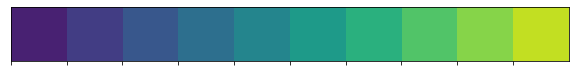

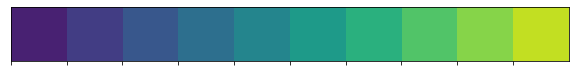

In [10]:
###################################
# Start creating the different trials based on the parameters given above
###################################
# Create empty dataframe 
sampleTrialOptions = pd.DataFrame(data=None, 
                                  columns=['MagReward_left', 'ProbReward_left', 'Options_left', 'MagReward_right',
                                                       'ProbReward_right', 'Options_right', 'ChoiceOption', 'ChoiceDimension',
                                                       'rewardRange', 'expectedValue_left', 'expectedValue_right',
                                                       'expectedValueSum', 'valueDifference', 'bestOption', 'worstOption',
                                                       'rewarded_left', 'rewarded_right', 'reward_left_feedback', 'reward_right_feedback', 
                                                       'itiPreFixationDuration', 'fixationDuration', 'stimulusDuration', 'itiPostStimulusDuration', 'feedbackDuration',
                                                       'itiPostFeedbackDuration', 'typeOfPilot', 'dots_left', 'dots_right',
                                                       'rgb_left', 'rgb_right'], 
                                  index=None)
# Start the loop:
for pilotversion in range(0, nrPilotVersions):
    print('Pilot version:', pilotversion)
    
    # Create an array of subject and block numbers
    subjects = [*range(1, nrSubjects+1, 1)]
    subjects = list(map(str, subjects))

    blocks = [*range(1, nrTestBlocksPerSubject+1, 1)]
    blocks = list(map(str, blocks))

    # Make all the different combo's between magnitude and probability
    choiceOptions = np.array(np.meshgrid(range(1, 11, 1), [x / 10.0 for x in range(1, 11, 1)])).T.reshape(-1,2)
    choiceOptions = pd.DataFrame(choiceOptions)
    choiceOptions.columns = ['MagReward', 'ProbReward']

    # Determine if a choice option is familiar or not:
    choiceOptions['Options'] = choiceOptions.apply(lambda x: 'familiar' 
                                                               if (
                                                                    (x['MagReward'] == MagnitudeRewardTraining) | (x['ProbReward'] == ProbabilityRewardTraining)
                                                                )  
                                                               else ('novel'), 
                                                   axis = 1 )

    # Get all the different potential left and right choice combinations
    #. Based on the example design file that I got from the main author it is allowed to
    #. have trials that have identical probility and magnitude value choice combinations
    #. So we are really interested in ALL potential left and right mag*prob combinations:
    choiceOptions['key'] = 1
    choiceOptionsLeft = choiceOptions
    choiceOptionsRight = choiceOptions 
    combinedChoiceOptions = pd.merge(choiceOptionsLeft, 
                                     choiceOptionsRight, 
                                     on = 'key', 
                                     how = 'outer',
                                     suffixes=('_left', '_right')
                                    ).drop('key',axis=1)

    # Oke so at this point we have ALL the different magnitude*reward combo's for left and right. 
    #. we now need to label the choice options to see if the combo is familiar, novel or a mixture.
    #. we do so by applying the custom function 'ChoiceOptions' to every single row:
    combinedChoiceOptions['ChoiceOption'] = combinedChoiceOptions.apply(lambda x: ChoiceOptions(x['Options_left'], x['Options_right']),axis=1)

    #. Oke, so now within novel or familiar we want to now if the choice combo is consistent, inconsistent or 1 dimensional:
    #. we do so by applying the custom function 'ChoiceDim' to every single row:
    combinedChoiceOptions['ChoiceDimension'] = combinedChoiceOptions.apply(lambda x: ChoiceDim(x['MagReward_left'], x['MagReward_right'], x['ProbReward_left'], x['ProbReward_right']),axis=1)

    # In the original paper they excluded any choice option where the expected value is outside the range
    #. of the expected value of the trained set of trials. Expected value is defined as magnitude * probability
    #. In the paper this means the expected value (magnitude times probability) had to be between 0.5 and 6.0 
    #. as they were trained on Magnitude of reward of 5 or with a reward probability of 0.6. 
    #. This translates to a minimum expected reward during training was 0.5 (5*0.1) and the 
    #. maximum was 6 (10*0.6).
    #. We do so by applying the custom function 'outsideFamiliarRange' to every single row:
    combinedChoiceOptions['rewardRange'] = combinedChoiceOptions.apply(lambda x: outsideFamiliarRange(x['MagReward_left'], x['MagReward_right'], x['ProbReward_left'], x['ProbReward_right']),axis=1)

    # We will also need to know what the sum of both the expected value choice alternatives is:
    combinedChoiceOptions['expectedValue_left'] = round(combinedChoiceOptions['MagReward_left']*combinedChoiceOptions['ProbReward_left'], 2)
    combinedChoiceOptions['expectedValue_right'] = round(combinedChoiceOptions['MagReward_right']*combinedChoiceOptions['ProbReward_right'], 2)
    combinedChoiceOptions['expectedValueSum'] = round(combinedChoiceOptions['expectedValue_left'] + combinedChoiceOptions['expectedValue_right'], 2)

    # We also want to know what the value difference is between the two choice alternatives: 
    combinedChoiceOptions['valueDifference'] = round(abs(combinedChoiceOptions['expectedValue_left']-combinedChoiceOptions['expectedValue_right']),2)

    # Finally we want to know the best and the worst option based on the expected value:
    combinedChoiceOptions.loc[(combinedChoiceOptions['expectedValue_left']>combinedChoiceOptions['expectedValue_right']), 'bestOption'] = combinedChoiceOptions['expectedValue_left']
    combinedChoiceOptions.loc[(combinedChoiceOptions['expectedValue_left']<combinedChoiceOptions['expectedValue_right']), 'bestOption'] = combinedChoiceOptions['expectedValue_right']
    combinedChoiceOptions.loc[(combinedChoiceOptions['expectedValue_left']>combinedChoiceOptions['expectedValue_right']), 'worstOption'] = combinedChoiceOptions['expectedValue_right']
    combinedChoiceOptions.loc[(combinedChoiceOptions['expectedValue_left']<combinedChoiceOptions['expectedValue_right']), 'worstOption'] = combinedChoiceOptions['expectedValue_left']

    # Rewarded if chosen?
    # We are going to generate a random number between 0 and 1 and check if the probabilty of that associated choice is smaller or equal to 
    #. that random number. We are using a uniform distribution to sample from. 
    combinedChoiceOptions['rewarded_left'] = combinedChoiceOptions.apply(lambda x: 1 if random.uniform(0, 1) <= x['ProbReward_left'] else 0, axis = 1 )
    combinedChoiceOptions['rewarded_right'] = combinedChoiceOptions.apply(lambda x: 1 if random.uniform(0, 1) <= x['ProbReward_right'] else 0, axis = 1 )

    ########
    # Assign trial timing to each trial
    itiDistribution = createITIDist(itiLowerRange, itiUpperRange)
    combinedChoiceOptions['itiPreFixationDuration'] = combinedChoiceOptions.apply(lambda x: round(np.random.choice(itiDistribution, 1)[0], 2), axis=1)
    combinedChoiceOptions['fixationDuration'] = fixationDuration
    combinedChoiceOptions['stimulusDuration'] = stimulusDuration
    combinedChoiceOptions['itiPostStimulusDuration'] = itiPostStimulusDuration
    combinedChoiceOptions['feedbackDuration'] = feedbackDuration
    combinedChoiceOptions['itiPostFeedbackDuration'] = totalTrialDuration-(combinedChoiceOptions['itiPreFixationDuration']+
                                                                           combinedChoiceOptions['fixationDuration']+
                                                                           combinedChoiceOptions['stimulusDuration']+
                                                                           combinedChoiceOptions['itiPostStimulusDuration']+
                                                                           combinedChoiceOptions['feedbackDuration'])
    ########
    # Select the trials that we are allowed to use:
    # We now know in which category every single choice combination would land. A number of categories are however
    #. excluded. So we are now going to drop all the choice combinations that do not fit the inclusion criteria of 
    #. the original paper:

    # Choice options are only pure familiar or novel, not mixed:
    combinedChoiceOptionsSel = combinedChoiceOptions[combinedChoiceOptions['ChoiceOption'] != 'mixed'].reset_index(drop = True)

    # Reward range is only within the familiar range:
    combinedChoiceOptionsSel = combinedChoiceOptionsSel[combinedChoiceOptionsSel['rewardRange'] == 'trained'].reset_index(drop = True)

    # Later we need to know the unique choice and dimension options:
    choiceOptions = combinedChoiceOptionsSel['ChoiceOption'].unique()
    choiceOptions.sort()

    choiceDimensions = combinedChoiceOptionsSel['ChoiceDimension'].unique()
    choiceDimensions.sort()

    ########
    # Generate the number of dots and the corresponding coordinates for the left and right stimulus:
    # If we are checking memory chuncking we want to have two versions: one that starts at 3 and the other at 13
    if (typeOfPilot == 'memoryChunking') & (pilotversion == 0):
        combinedChoiceOptionsSel['typeOfPilot'] = pilotversion
        combinedChoiceOptionsSel['dots_left'] = combinedChoiceOptionsSel.apply(lambda x: createDots(nDots = int(numberOfDotsMagnitudeRatio*x['MagReward_left']), 
                                                                                                   canvasDim = canvasDim, 
                                                                                                   dotRadius = dotRadius, 
                                                                                                   borderMargin = borderMargin, 
                                                                                                   dotsMargin = dotsMargin),
                                                                              axis=1)
        combinedChoiceOptionsSel['dots_right'] = combinedChoiceOptionsSel.apply(lambda x: createDots(nDots = int(numberOfDotsMagnitudeRatio*x['MagReward_right']), 
                                                                                                   canvasDim = canvasDim, 
                                                                                                   dotRadius = dotRadius, 
                                                                                                   borderMargin = borderMargin, 
                                                                                                   dotsMargin = dotsMargin),
                                                                              axis=1)
    elif (typeOfPilot == 'memoryChunking') & (pilotversion == 1):
        combinedChoiceOptionsSel['typeOfPilot'] = pilotversion
        combinedChoiceOptionsSel['dots_left'] = combinedChoiceOptionsSel.apply(lambda x: createDots(nDots = int((numberOfDotsMagnitudeRatio*x['MagReward_left'])+10), 
                                                                                                   canvasDim = canvasDim, 
                                                                                                   dotRadius = dotRadius, 
                                                                                                   borderMargin = borderMargin, 
                                                                                                   dotsMargin = dotsMargin),
                                                                              axis=1)
        combinedChoiceOptionsSel['dots_right'] = combinedChoiceOptionsSel.apply(lambda x: createDots(nDots = int((numberOfDotsMagnitudeRatio*x['MagReward_right'])+10), 
                                                                                                   canvasDim = canvasDim, 
                                                                                                   dotRadius = dotRadius, 
                                                                                                   borderMargin = borderMargin, 
                                                                                                   dotsMargin = dotsMargin),
                                                                              axis=1)
    else:
        combinedChoiceOptionsSel['typeOfPilot'] = pilotversion
        combinedChoiceOptionsSel['dots_left'] = combinedChoiceOptionsSel.apply(lambda x: createDots(nDots = int(numberOfDotsMagnitudeRatio*x['MagReward_left']), 
                                                                                                   canvasDim = canvasDim, 
                                                                                                   dotRadius = dotRadius, 
                                                                                                   borderMargin = borderMargin, 
                                                                                                   dotsMargin = dotsMargin),
                                                                              axis=1)
        combinedChoiceOptionsSel['dots_right'] = combinedChoiceOptionsSel.apply(lambda x: createDots(nDots = int(numberOfDotsMagnitudeRatio*x['MagReward_right']), 
                                                                                                   canvasDim = canvasDim, 
                                                                                                   dotRadius = dotRadius, 
                                                                                                   borderMargin = borderMargin, 
                                                                                                   dotsMargin = dotsMargin),
                                                                              axis=1)

    ########
    # Color scheme
    # Assign the associated RGB code as an array into the dataframe
    pal = sns.color_palette(colorScheme, 10)
    # Because python normalizes the RGB codes between 0 and 1 (instead of 0-255) we need to multiply all RGB values
    #. so that we can actually use them in a website 
    palRGB = []
    for i in range(0,len(pal)):
        tmpRGB = [[int(round((z * 255),0)) for z in pal[i]]]
        palRGB += tmpRGB
    # Lets assign those colors to the probability of reward
    for i in range(1, 11):
        combinedChoiceOptionsSel.loc[(combinedChoiceOptionsSel['ProbReward_left'] == i/10 ), 'rgb_left'] = str(palRGB[i-1])
        combinedChoiceOptionsSel.loc[(combinedChoiceOptionsSel['ProbReward_right'] == i/10), 'rgb_right'] = str(palRGB[i-1])
        
    #####
    # Create the feedback points 
    #. We are going to use a linear relationship between the number of dots on the screen and the amount of reward
    if (typeOfPilot == 'memoryChunking') & (pilotversion == 0):
        combinedChoiceOptionsSel['reward_left_feedback'] = pd.to_numeric((numberOfDotsMagnitudeRatio*combinedChoiceOptionsSel['MagReward_left'])*combinedChoiceOptionsSel['rewarded_left'], downcast='integer')
        combinedChoiceOptionsSel['reward_right_feedback'] = pd.to_numeric((numberOfDotsMagnitudeRatio*combinedChoiceOptionsSel['MagReward_right'])*combinedChoiceOptionsSel['rewarded_right'], downcast='integer')
    elif (typeOfPilot == 'memoryChunking') & (pilotversion == 1):
        combinedChoiceOptionsSel['reward_left_feedback'] = pd.to_numeric(((numberOfDotsMagnitudeRatio*combinedChoiceOptionsSel['MagReward_left'])+10)*combinedChoiceOptionsSel['rewarded_left'], downcast='integer')
        combinedChoiceOptionsSel['reward_right_feedback'] = pd.to_numeric(((numberOfDotsMagnitudeRatio*combinedChoiceOptionsSel['MagReward_right'])+10)*combinedChoiceOptionsSel['rewarded_right'], downcast='integer')
    else:
        combinedChoiceOptionsSel['reward_left_feedback'] = pd.to_numeric((numberOfDotsMagnitudeRatio*combinedChoiceOptionsSel['MagReward_left'])*combinedChoiceOptionsSel['rewarded_left'], downcast='integer')
        combinedChoiceOptionsSel['reward_right_feedback'] = pd.to_numeric((numberOfDotsMagnitudeRatio*combinedChoiceOptionsSel['MagReward_right'])*combinedChoiceOptionsSel['rewarded_right'], downcast='integer')
        
    ###################################

    ###################################
    # Oke, after all this, how many potential trials did we then end up with?
    ###################################
    # Print the number of trials per type of trial
    print('\nAfter filtering, the number of potential trials to sample from:\n')
    print(combinedChoiceOptionsSel.groupby(['ChoiceOption', 'ChoiceDimension']).size())

    # Print the mean expected value sum per trial type:
    print('\nThe overal mean expected value per trial type where 6.0 +/- 0.02 is oke:\n')
    print(combinedChoiceOptionsSel.groupby(['ChoiceOption', 'ChoiceDimension'])['expectedValueSum'].mean())

    # How many trials are we going to get per subject
    print('\nExpected number of trials per subject?\n')
    print('Total number of training trials:', nrTrialsPerTrainingBlock)
    print('Total number of test trials per block:', nrTrialsPerTestBlock)
    print('Total number of test trials per subject:', nrTrialsPerTestBlock*nrTestBlocksPerSubject)

    # Show me the colors that we are using
    print('\nWhich colors are we using?\n')
    sns.palplot(pal)
    
    # Append the trial selection to the main dataframe
    sampleTrialOptions = sampleTrialOptions.append(combinedChoiceOptionsSel, ignore_index = True)

###############################################################################################     

In [122]:
############################################################################################### 
# What background color should we use?
############################################################################################### 

# The original paper uses 125, 125, 125 (grey) but visually we also liked black. So what happens
#. to the different contrast with the background?
def get_contrast_color(r, g, b, background):

    r1 = r 
    g1 = g 
    b1 = b 
    
    if background == 'black':
        r2_back_color = 0
        g2_back_color = 0 
        b2_back_color = 0 
    elif background == 'grey':
        r2_back_color = 125 
        g2_back_color = 125 
        b2_back_color = 125 
    elif background == 'white':
        r2_back_color = 255 
        g2_back_color = 255 
        b2_back_color = 255
        
    # Calc contrast ratio
    l1 = 0.2126 * pow(r1 / 255, 2.2) + 0.7152 * pow(g1 / 255, 2.2) + 0.0722 * pow(b1 / 255, 2.2)

    l2 = 0.2126 * pow(r2_back_color / 255, 2.2) + 0.7152 * pow(g2_back_color / 255, 2.2) + 0.0722 * pow(b2_back_color / 255, 2.2)

    if l1 > l2:
        contrast_ratio = (l1 + 0.05) / (l2 + 0.05)
    else:
        contrast_ratio = (l2 + 0.05) / (l1 + 0.05)

    return contrast_ratio

listcontrastBlack = []
for col in range(0, 10):
    listcontrastBlack.append(get_contrast_color(palRGB[col][0], palRGB[col][1], palRGB[col][2], 'black'))

listcontrastWhite = []
for col in range(0, 10):
    listcontrastWhite.append(get_contrast_color(palRGB[col][0], palRGB[col][1], palRGB[col][2], 'white'))

listcontrastGrey = []
for col in range(0, 10):
    listcontrastGrey.append(get_contrast_color(palRGB[col][0], palRGB[col][1], palRGB[col][2], 'grey'))
    
print(listcontrastBlack)
print(listcontrastWhite)
print(listcontrastGrey)

# As you can see you would get an order of magnitude difference in contrast if you would use either white or black
#. over the range of colors. Whereas if you would use grey the contrast is in the same order (and poor in general).
############################################################################################### 


[1.6728240369353546, 2.2068309821462107, 2.914487963103652, 3.832618030840643, 4.875346426927424, 6.196479336208649, 7.718969258463491, 9.663091191149443, 11.751812711896498, 13.998114352866219]
[12.553621622075923, 9.515907729180444, 7.205382305863771, 5.479283307393374, 4.307386216498009, 3.389021226503269, 2.720570492876944, 2.173217615832311, 1.7869583624951284, 1.500202060836865]
[3.088904155563034, 2.3414539495861586, 1.7729334224845377, 1.3482150001997406, 1.0598617342710257, 1.199196390234705, 1.4938418364428458, 1.8700851638803875, 2.274312656942275, 2.709036420723496]


## Creating training json files


Pilot version: 0

subject: 1

number of mini training block: 0

Training block succes

number of mini training block: 1

Training block succes

number of mini training block: 2

Training block succes

number of mini training block: 3

Training block succes

number of mini training block: 4

Training block succes

number of mini training block: 5

Training block succes

number of mini training block: 6

Training block succes

number of mini training block: 7

Training block succes

number of mini training block: 8

Training block succes

number of mini training block: 9

Training block succes

subject: 2

number of mini training block: 0

Training block succes

number of mini training block: 1

Training block succes

number of mini training block: 2

Training block succes

number of mini training block: 3

Training block succes

number of mini training block: 4

Training block succes

number of mini training block: 5

Training block succes

number of mini training block: 6

Training bl

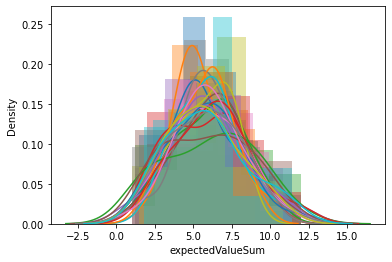

In [28]:
###############################################################################################  
# Create json files that can be used for the training block
###############################################################################################  

for pilotType in range(0, nrPilotVersions):
    print('\nPilot version:', pilotType)
    
    # The training stimuli that we should only consider for training are those that we will
    #. later on consider familiar and 1D:
    tmpTrainingTrials = sampleTrialOptions[((sampleTrialOptions['ChoiceOption'] == 'familiar') & 
                              (sampleTrialOptions['ChoiceDimension'] == '1D') &
                                                 (sampleTrialOptions['typeOfPilot'] == pilotType ))]

    # Start the loop per subject where we are going to sample the number of training trails
    #. to match the number that we've specified above. 
    #. We have a single requirement: the sum of the expected value during training should
    #. also be within the allowed range. At the end we also generate a single
    #. plot where you will hopefully see a large number of histograms on top of one and other
    #. with a density line that should be centered around the sum of the expected value.
    #. Lets start the for and while loop (pretty quick):

    for subject in subjects:
        subj = subject
        print('\nsubject:', subj)
        
        # Create empty dataframe for a single subject
        outputTrainingSubject = pd.DataFrame(data=None, 
                                  columns=['pilotType', 'subjectNr', 'blockType', 'block', 'trialNr', 'MagReward_left',
                                           'ProbReward_left', 'Options_left', 'MagReward_right',
                                           'ProbReward_right', 'Options_right', 'ChoiceOption', 'ChoiceDimension',
                                           'rewardRange', 'expectedValue_left', 'expectedValue_right',
                                           'expectedValueSum', 'valueDifference', 'bestOption', 'worstOption',
                                           'rewarded_left', 'rewarded_right', 'reward_left_feedback', 'reward_right_feedback', 
                                           'itiPreFixationDuration', 'fixationDuration', 'stimulusDuration','itiPostStimulusDuration', 'feedbackDuration',
                                           'itiPostFeedbackDuration', 'dots_left', 'dots_right', 'rgb_left',
                                           'rgb_right'], 
                                  index=None)
        # Create training blocks
        for trainingBlock in range(0, nrTrainingBlock):
            print('\nnumber of mini training block:', trainingBlock)
            # Start my while counter:
            a = 0
            while a < 20001:
                tmpTrainingSample = tmpTrainingTrials.sample(n = nrTrialsPerTrainingBlock, replace = onlyUniqueTrials) 
                expectedValueSumTraining = tmpTrainingSample['expectedValueSum'].mean() # This should be within the +/- range of expected value
                if ((expectedValueSumTraining >= float(averageExpectedValuePerType-rangeOfExpectedValue)) & (expectedValueSumTraining <= float(averageExpectedValuePerType+rangeOfExpectedValue))):
                    # If you end up here this means that the sampling was a success and that you managed to randomly sample trials that on average 
                    #. have an expected value that is within your range.
                    print('\nTraining block succes')

                    # Shuffle the training trials:
                    outputTrainingSample = tmpTrainingSample.sample(frac=1).reset_index(drop=True)
                    
                    # Assign the last columns that we need:
                    outputTrainingSample['pilotType'] = pilotType
                    outputTrainingSample['subjectNr'] = int(subj)
                    outputTrainingSample['blockType'] = 0 # Where block type 0 is equal to training blocks
                    outputTrainingSample['block'] = trainingBlock
                    outputTrainingSample['trialNr'] = outputTrainingSample.index

                    # move the columns to a nicer spot
                    cols_to_move = ['pilotType','subjectNr', 'blockType', 'block', 'trialNr']
                    outputTrainingSample = outputTrainingSample[cols_to_move + [ col for col in outputTrainingSample.columns if col not in cols_to_move ] ]

                    # append to empty dataframe for that subject And write to output file if number of mini blocks is max:
                    outputTrainingSubject = outputTrainingSubject.append(outputTrainingSample)
                    if trainingBlock == (nrTrainingBlock-1):
                        outputTrainingSubject.to_json(taskDesignOutputDir+'/designFile_pilot-V'+str(pilotType)+'_sub-'+str(subj)+'.json', orient="records" )
                        with warnings.catch_warnings():
                            warnings.simplefilter(action='ignore', category=FutureWarning)

                            # Show me the expected value sum per succesful sample over all subjects
                            sns.distplot(tmpTrainingSample[((tmpTrainingSample['ChoiceOption'] == 'familiar') & 
                                          (tmpTrainingSample['ChoiceDimension'] == '1D'))]['expectedValueSum'])
                    break
                elif a == 20000:
                    # So chances are a that the single conditional statement will be pretty quick to converge 
                    #. on the average expected value range. Just in case you don't converge we are going to 
                    #. restart the counter for the while loop. 
                    print('\tno convergence on training block, trying again')
                    a = 0 
                else:
                    a +=1  
###############################################################################################   

## Creating test json files

In [ ]:
###############################################################################################  
# Create json files that can be used for the training block option 1
###############################################################################################  
# In the original paper they basically generated a lot of different samples, kept all of them
#. in a matrix and then searched through it to select those combinations that fit the rules.
#. Initial I skipped this and created a nested nested for-loop which turned out to work but 
#. depending on the strict inclusion parameters can take for ever (see option 2 below) for
#. the code. 
#. I've now tried to do the same as the original authors by creating a large collection of
#. samples that I can then start to search through which hopefully is a bit quicker.
#. Timingwise: it is about 18 min per 100 blocks of 1000 samples of 30 trials.
#. After 500.000 per trial type and the original restrictions we still don't have enough
#. options to make combinations. So we are going to be less restrictive and use option 2 (see below)

# Per choice option
for choiceOption in choiceOptions:
    print('Choice option:', choiceOption)
    # Per choice dimension
    for choiceDimension in choiceDimensions:
        print('Choice dimension:', choiceDimension)
        
        # Select all the trials that fall in that category to sample from
        tmpBlock = sampleTrialOptions[(sampleTrialOptions['ChoiceOption'] == choiceOption) & (sampleTrialOptions['ChoiceDimension'] == choiceDimension)] 
        tmpBlock.drop(['typeOfPilot'], axis = 1 , inplace=True)
        blocks = 500 # each block has x samples
        samples = 1000 # and each sample has n trials
        numberOftrialsToSample = int(round(nrTrialsPerTestBlock/6, 0))
        trialType = choiceOption+'-'+choiceDimension
        
        # Start the for loop to sample the trials
        for block in range(0, blocks):
            print(block)
            # Empty dataframe
            trialOptions = pd.DataFrame(data=None, 
                                          columns=['trialType', 'sample', 'expectedValueSumMean', 'valueDifferenceMean', 'valueDifferenceStd', 'MagReward_left',
                                                   'ProbReward_left', 'Options_left', 'MagReward_right',
                                                   'ProbReward_right', 'Options_right', 'ChoiceOption', 'ChoiceDimension',
                                                   'rewardRange', 'expectedValue_left', 'expectedValue_right',
                                                   'expectedValueSum', 'valueDifference', 'bestOption', 'worstOption',
                                                   'rewarded_left', 'rewarded_right', 'reward_left_feedback', 'reward_right_feedback', 
                                                   'itiPreFixationDuration', 'fixationDuration', 'stimulusDuration','itiPostStimulusDuration', 'feedbackDuration',
                                                   'itiPostFeedbackDuration', 'dots_left', 'dots_right', 'rgb_left',
                                                   'rgb_right'], 
                                          index=None)
            # The actual sampling
            for sampleN in range(0, samples):
                tmpSample = tmpBlock.sample(n = numberOftrialsToSample, replace = onlyUniqueTrials) 
                tmpSample['trialType'] = trialType
                tmpSample['sample'] = sampleN
                tmpSample['expectedValueSumMean'] = tmpSample['expectedValueSum'].mean() 
                tmpSample['valueDifferenceMean'] = tmpSample['valueDifference'].mean() 
                tmpSample['valueDifferenceStd'] = tmpSample['valueDifference'].std()   
                trialOptions = trialOptions.append(tmpSample)
            trialOptions.to_csv(taskDesignDir+'/sampleTrialBlocks/choiceOptionSampleMainDF-'+trialType+'_'+str(block)+'.csv')

In [ ]:
####
# After you created all those csv files lets see how many combinations we can make with them..
files = glob.glob('/Users/mckitchen/Documents/Werk.nosynch/Shared/Risk-Reward-DM/Paradigm/GenerateDesignFiles/sampleTrialBlocks/*.csv')

# create empty list
listOfFiles = []

# loop through list of files and read each one into a dataframe and append to list
for file in files:
    dfTmp = pd.read_csv(file)
    # Lets delete the rows for which we already know that they don't fit 
    dfSamplesSelection = dfTmp[ (dfTmp['expectedValueSumMean'] >= float(averageExpectedValuePerType-rangeOfExpectedValue)) & 
                                  (dfTmp['expectedValueSumMean'] <= float(averageExpectedValuePerType+rangeOfExpectedValue))
                              ]
    listOfFiles.append(dfSamplesSelection)
    
# concatenate our list of dataframes into single dataframe
dfSamples = pd.concat(listOfFiles, axis=0)
dfSamples.sort_values(by = ['trialType', 'sample'], inplace=True)


# Dropping all samples that fall outside of the first inclusion criteria that holds for all trial types
# The average expected value sum mean criteria
print(dfSamples.shape)
dfSamplesSelection = dfSamples[ (dfSamples['expectedValueSumMean'] >= float(averageExpectedValuePerType-rangeOfExpectedValue)) & 
                                  (dfSamples['expectedValueSumMean'] <= float(averageExpectedValuePerType+rangeOfExpectedValue))
                              ]
print(dfSamplesSelection.shape)
# Lets select a sample of the first choice dimension trial type

# Free up memory
del dfSamples

import gc
gc.collect()

# What is the smallest group?
print('\n', dfSamplesSelection.groupby(['trialType'])['sample'].nunique())

# Probably 'novel-inconsistent'
valueDifferenceMeanUniqueNovIncon = dfSamplesSelection[(dfSamplesSelection['trialType'] == 'novel-inconsistent')]['valueDifferenceMean'].unique()
valueDifferenceStdUniqueNovIncon = dfSamplesSelection[(dfSamplesSelection['trialType'] == 'novel-inconsistent')]['valueDifferenceStd'].unique()

# Value Difference mean difference
numberOfTrialTypesThatFitMean = []
for i in (valueDifferenceMeanUniqueNovIncon):
    tmp = dfSamplesSelection[
                                (dfSamplesSelection['trialType'] != 'novel-inconsistent') & 
                                (abs(dfSamplesSelection['valueDifferenceMean'] - i ) <= averageDifferenceValueCrit)]
    numberOfTrialTypesThatFitMean.append(tmp['trialType'].nunique())
    
# We need 5 unique trial types to be able to make a combination
print('\nNumber of trial type samples that fit the mean difference: ', numberOfTrialTypesThatFitMean.count(5))

# Value Difference std difference
numberOfTrialTypesThatFitStd = []
for i in (valueDifferenceStdUniqueNovIncon):
    tmp = dfSamplesSelection[
                                (dfSamplesSelection['trialType'] != 'novel-inconsistent') & 
                                (abs(dfSamplesSelection['valueDifferenceStd'] - i ) <= stdDifferenceValueCrit)]
    numberOfTrialTypesThatFitStd.append(tmp['trialType'].nunique())
    
# We need 5 unique trial types to be able to make a combination
print('\nNumber of trial type samples that fit the Std difference: ', numberOfTrialTypesThatFitStd.count(5))


In [29]:
###############################################################################################  
# Create json files that can be used for the training block option 2
###############################################################################################  
# Random select the trials given the long list of conditinal statements:
#. - the average sum of expected values needs to be within a certain range
#. - the mean difference between choice options over choice dimensions within a choice option should be fairly small
#. - the variance difference between choice options over choice dimensions within a choice option should be fairly small
#. - the best and the worst option witthin choice options need to correlate fairly low
#.
#. The biggest problem with these statements is that they are all nested so if your random sampling figured out
#. the first 3 rules and fails at the 4th you have to start all over..


for pilotType in range(0, nrPilotVersions):
    print('\nPilot version:', pilotType)
    
    for subject in subjects:
        subj = int(subject)
        print('subject:', subj)

        trialSelectionPerSubject = pd.DataFrame(data=None, 
                                      columns=['trialType', 'sample', 'expectedValueSumMean', 'valueDifferenceMean', 'valueDifferenceStd', 'MagReward_left',
                                                   'ProbReward_left', 'Options_left', 'MagReward_right',
                                                   'ProbReward_right', 'Options_right', 'ChoiceOption', 'ChoiceDimension',
                                                   'rewardRange', 'expectedValue_left', 'expectedValue_right',
                                                   'expectedValueSum', 'valueDifference', 'bestOption', 'worstOption',
                                                   'rewarded_left', 'rewarded_right', 'reward_left_feedback', 'reward_right_feedback', 
                                                   'itiPreFixationDuration', 'fixationDuration', 'stimulusDuration','itiPostStimulusDuration', 'feedbackDuration',
                                                   'itiPostFeedbackDuration', 'dots_left', 'dots_right', 'rgb_left',
                                                   'rgb_right'], 
                                      index=None)
        
        # Start the loop per block
        for block in blocks:
            print('block:', block)

            # The eventual familiar and novel trials are not allowed to correlate highly with one and other
            #. on the worst and best trials so we are going to check that:
            corCheck = 0
            while corCheck < 20001:
                # Create empty dataframe for the eventual trials
                trialSelection = pd.DataFrame(data=None, 
                                      columns=['trialType', 'sample', 'expectedValueSumMean', 'valueDifferenceMean', 'valueDifferenceStd', 'MagReward_left',
                                                   'ProbReward_left', 'Options_left', 'MagReward_right',
                                                   'ProbReward_right', 'Options_right', 'ChoiceOption', 'ChoiceDimension',
                                                   'rewardRange', 'expectedValue_left', 'expectedValue_right',
                                                   'expectedValueSum', 'valueDifference', 'bestOption', 'worstOption',
                                                   'rewarded_left', 'rewarded_right', 'reward_left_feedback', 'reward_right_feedback', 
                                                   'itiPreFixationDuration', 'fixationDuration', 'stimulusDuration','itiPostStimulusDuration', 'feedbackDuration',
                                                   'itiPostFeedbackDuration', 'dots_left', 'dots_right', 'rgb_left',
                                                   'rgb_right'], 
                                      index=None)

                print('Corcheck:', corCheck)
                # familiar vs novel 
                for choiceDimension in choiceDimensions:
                    print('Choice dimension:',choiceDimension)
                    # Select all trials that are familiar and match the specific choice dimension
                    tmpBlockA1 = sampleTrialOptions[(sampleTrialOptions['ChoiceOption'] == choiceOptions[0]) 
                                                        & (sampleTrialOptions['ChoiceDimension'] == choiceDimension) 
                                                         & (sampleTrialOptions['typeOfPilot'] == pilotType)] 
                    # Start my while counter:
                    a = 0
                    while a < 20001:
                        # We are initially going to sample 20k times from the main data frame to select a number of trials. Whether they are unique or not
                        #. we specify that in the beginning. 
                        tmpSampleA1 = tmpBlockA1.sample(n = int(round(nrTrialsPerTestBlock/6, 0)), replace = onlyUniqueTrials) 
                        expectedValueSumA1 = tmpSampleA1['expectedValueSum'].mean() # This should be within the +/- range of expected value
                        differenceValueSumA1 = tmpSampleA1['valueDifference'].mean() # This should be smaller or equal to the allowed mean difference
                        differenceValueVarA1 = tmpSampleA1['valueDifference'].std()  # This should be smaller or equal to the allowed variance difference

                        # The criteria to stop the while loop is that the average expected value for these trials needs to be within the range that we specified:
                        if ((expectedValueSumA1 >= float(averageExpectedValuePerType-rangeOfExpectedValue)) & (expectedValueSumA1 <= float(averageExpectedValuePerType+rangeOfExpectedValue))):
                            # If you end up here this means that the sampling was a success and that you managed to randomly sample trials that on average 
                            #. have an expected value that is within your range.
                            print('\tFamiliar block succes')
                            # The next criteria is that mean value difference between choice alternatives is similar for the novel and the familiar trials.
                            #. So now that we have the familiar trials, we move on to the novel trials:
                            tmpBlockA2 = sampleTrialOptions[(sampleTrialOptions['ChoiceOption'] == choiceOptions[1]) 
                                                                    & (sampleTrialOptions['ChoiceDimension'] == choiceDimension)
                                                                     & (sampleTrialOptions['typeOfPilot'] == pilotType) ] 

                            # Start the second while counter:
                            b = 0
                            while b < 20001:
                                # Again, we are initially going to sample 20k times from this main data frame:
                                tmpSampleA2 = tmpBlockA2.sample(n = int(round(nrTrialsPerTestBlock/6, 0)), replace = onlyUniqueTrials) 
                                expectedValueSumA2 = tmpSampleA2['expectedValueSum'].mean()
                                differenceValueSumA2 = tmpSampleA2['valueDifference'].mean()
                                differenceValueVarA2 = tmpSampleA2['valueDifference'].std()

                                # The criteria to stop the while loops is now three fold:
                                #. the average expected value of these trials need to be within the specified range AND
                                #. the average difference between choice alternatives cannot differ that much between the novel and the familiar choice options AND
                                #. the variance of the difference between choice alternatives cannot differ too much either:
                                if ((expectedValueSumA2 >= float(averageExpectedValuePerType-rangeOfExpectedValue)) & (expectedValueSumA2 <= float(averageExpectedValuePerType+rangeOfExpectedValue))
                                           &
                                           (abs(differenceValueSumA1 - differenceValueSumA2) <= averageDifferenceValueCrit)
                                           &
                                           (abs(differenceValueVarA1 - differenceValueVarA2) <= stdDifferenceValueCrit)
                                           ):
                                    print('\tNovel block succes')
                                    trialSelection = trialSelection.append(tmpSampleA1, ignore_index = True)
                                    trialSelection = trialSelection.append(tmpSampleA2, ignore_index = True)
                                    break

                                elif b == 20000:
                                    # So chances are that you won't make it in 20k random samples as the criteria are conditional statements
                                    #. In that case just keep on going with sampling the familiar trials again and again and again until either
                                    #. the universe collapses on itself or you get bored..
                                    print('\tno convergence on novel block, trying again')
                                    b = 0 
                                else: 
                                    # No succes just yet so keep on counting.
                                    b +=1
                            break

                        elif a == 20000:
                            # So chances are a bit better for a single conditional statement but just in case you don't converge on the average 
                            #. expected value we are going to restart the counter for the while loop. 
                            print(choiceDimension)
                            print('\tno convergence on familiar block, trying again')
                            a = 0 
                        else:
                            a +=1  
                # Oke so now we have a list of our trials that match the rules regarding mean expected reward and mean and variance in 
                #. the reward differences. Now we only need to check if the correlation between the best and the worst option is lower
                #. than our max correlation criteria; note that where the choices are equal the current value is a NaN which means that
                #. that pair is not taken into account when correlating the best and worst (if you replace the NaN value with 0 you 
                #. inflate the correlation coefficient. )
                corrFamiliar = trialSelection[trialSelection['ChoiceOption'] == 'familiar']['bestOption'].corr(trialSelection[trialSelection['ChoiceOption'] == 'familiar']['worstOption'])
                corrNovel = trialSelection[trialSelection['ChoiceOption'] == 'novel']['bestOption'].corr(trialSelection[trialSelection['ChoiceOption'] == 'novel']['worstOption'])

                if ((abs(corrFamiliar) <= maxCorrelationBestWorst) & (abs(corrNovel) <= maxCorrelationBestWorst)):
                    print('\tCorrelation criteria succes')
                    # Oke success, 

                    # Pseudo randomize the trials:
                    trialSelection['type_of_trial'] = trialSelection['ChoiceOption']+'_'+trialSelection['ChoiceDimension']
                    success = 0
                    while success == 0:
                        # Pseudorandomize the type of trials per block per subject where no more than N of the same trial types can be shown consecutively 
                        trialSelectionPseudo = Pseudorandomizer(trialSelection, max_identical_iters={'type_of_trial': maximumTrialTypeRep}).run()
                        # Check if pseudorandomizer worked:
                        groups = groupby(trialSelectionPseudo['type_of_trial'])
                        result = [(label, sum(1 for _ in group)) for label, group in groups]
                        rep = 0
                        for i in range(0, len(result)):
                            if result[i][1] > rep:
                                rep = result[i][1]
                        if (rep <= maximumTrialTypeRep):
                            print('\tPseudoRandomize succes')
                            success = 1
                            # Assign the last columns that we need:
                            trialSelectionPseudo['block'] = block # Where block 0 is equal to training block
                            trialSelectionPseudo['trialNr'] = trialSelectionPseudo.index
                            trialSelectionPseudo['pilotType'] = pilotType
                            trialSelectionPseudo['subjectNr'] = subj
                            trialSelectionPseudo['blockType'] = 1
                            
                            # move the columns to a nicer spot
                            cols_to_move = ['pilotType', 'subjectNr', 'blockType', 'block', 'trialNr']
                            outputTestBlock = trialSelectionPseudo[cols_to_move + [col for col in trialSelectionPseudo.columns if col not in cols_to_move ] ]
                            
                            # Append the selected trials to the main dataframe for a given subject
                            trialSelectionPerSubject = trialSelectionPerSubject.append(outputTestBlock, ignore_index = True)
                    break
                elif corCheck == 20000:
                    print('\tno convergence on the correlation, trying again')
                    corCheck = 0
                else:
                    corCheck +=1

        # And write the total number of blocks for a given subject to an output file:
        trialSelectionPerSubject.to_json(taskDesignOutputDir+'/designFile_pilot-V'+str(pilotType)+'_sub-'+str(subj)+'_testBlocks'+'.json', orient = 'records' )
   
        subj += 1
############################################################################################### 


Pilot version: 0
subject: 1
block: 1
Corcheck: 0
Choice dimension: 1D
	Familiar block succes
	Novel block succes
Choice dimension: consistent
	Familiar block succes
	Novel block succes
Choice dimension: inconsistent
	Familiar block succes
	Novel block succes
	Correlation criteria succes
pseudorandomizer running
Finished Pseudorandomizer
	PseudoRandomize succes
block: 2
Corcheck: 0
Choice dimension: 1D
	Familiar block succes
	Novel block succes
Choice dimension: consistent
	Familiar block succes
	Novel block succes
Choice dimension: inconsistent
	Familiar block succes
	Novel block succes
	Correlation criteria succes
pseudorandomizer running
Finished Pseudorandomizer
	PseudoRandomize succes
subject: 2
block: 1
Corcheck: 0
Choice dimension: 1D
	Familiar block succes
	Novel block succes
Choice dimension: consistent
	Familiar block succes
	Novel block succes
Choice dimension: inconsistent
	Familiar block succes
	Novel block succes
Corcheck: 1
Choice dimension: 1D
	Familiar block succes
	No